In [3]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy as scs

from arch import arch_model
#import pandas_datareader.data as web

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
p = print

#p('Machine: {} {}\n'.format(os.uname().sysname, os.uname().machine()))
p(sys.version)

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]


In [8]:
# Reading the data

data = pd.read_csv(r'C:\Users\kmoudgalya\Desktop\Pork Price Prediction Challenge\FoodPriceIndexData_Updated\MRDS_Index_Data_D_Labs_Training_Updated.csv', index_col = ['Date'], parse_dates = ['Date'])
data.dropna(inplace=True)
data.astype(np.float)
print(data)
data_Ham = data.drop(['Pork_Chops_Index', 'Bacon_Index'] , axis = 1)
data_Pork_Chops = data.drop( ['Ham_Index', 'Bacon_Index'], axis = 1)
data_Bacon = data.drop( ['Ham_Index', 'Pork_Chops_Index'], axis = 1)

            Beef_CS_LiveWgt_PerHd  Beef_CS_Slaughter_Cnt  Beef_ME_Exp_cwt  \
Date                                                                        
2007-01-01                   1290                 2800.3         88015.60   
2007-02-01                   1274                 2561.2         88273.90   
2007-03-01                   1260                 2793.0         92747.49   
2007-04-01                   1235                 2701.4        105205.87   
2007-05-01                   1232                 3051.4        126889.87   
2007-06-01                   1250                 3076.5        132357.45   
2007-07-01                   1269                 2903.1        165174.68   
2007-08-01                   1279                 3132.1        132838.23   
2007-09-01                   1290                 2664.6        126755.30   
2007-10-01                   1300                 3102.0        136387.79   
2007-11-01                   1304                 2830.7        121055.02   

# data_Ham.Ham_Index, we'll do ARIMA for this and then try it out on 
# data_Pork_Chops.Pork_Chops_Index and
# data_Bacon.Bacon_Index 

In [37]:
def tsplot(y, lags=None, figsize=(10,8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize = figsize)
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.stats.probplot(y, sparams = (y.mean(), y.std()), plot = pp_ax)
        
        plt.tight_layout()
    return

# Ham Index Plot

HAM INDEX: 


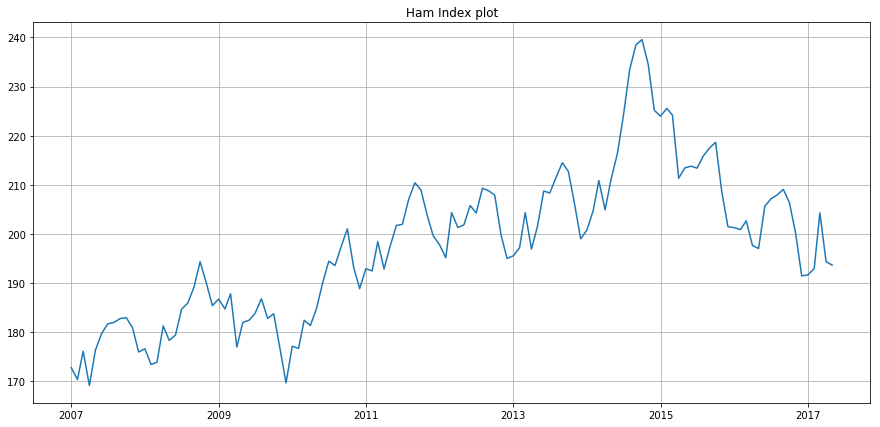

In [38]:
print("HAM INDEX: ")
plt.figure(figsize = (15,7))
plt.plot(data.Ham_Index)
plt.title('Ham Index plot')
plt.grid(True)
plt.show()

# Random Seed

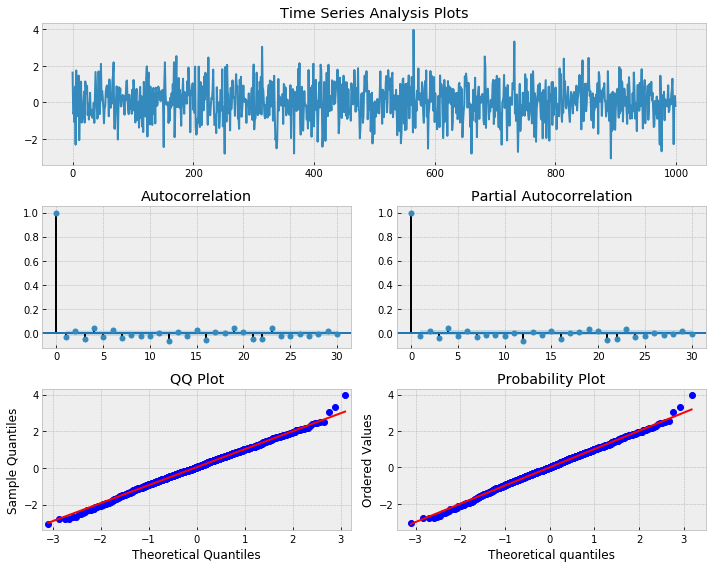

In [9]:
np.random.seed(1)

randser = np.random.normal(size=1000)
tsplot(randser, lags = 30)

In [10]:
p("Random Series\n ---------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
  .format(randser.mean(), randser.var(), randser.std()))

Random Series
 ---------------
mean: 0.039
variance: 0.962
standard deviation: 0.981


# Random Walk without a drift

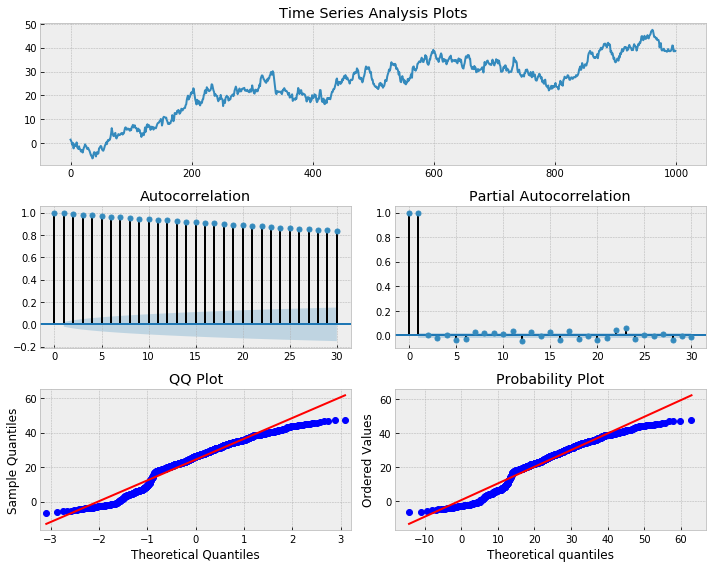

In [11]:
## Random Walk without a drift 

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]
    
_ = tsplot(x, lags=30)

# Note that our curve looks a lot like this, so potentially, the RANDOM WALK model could prove very useful

# First difference of the Random Walk series:

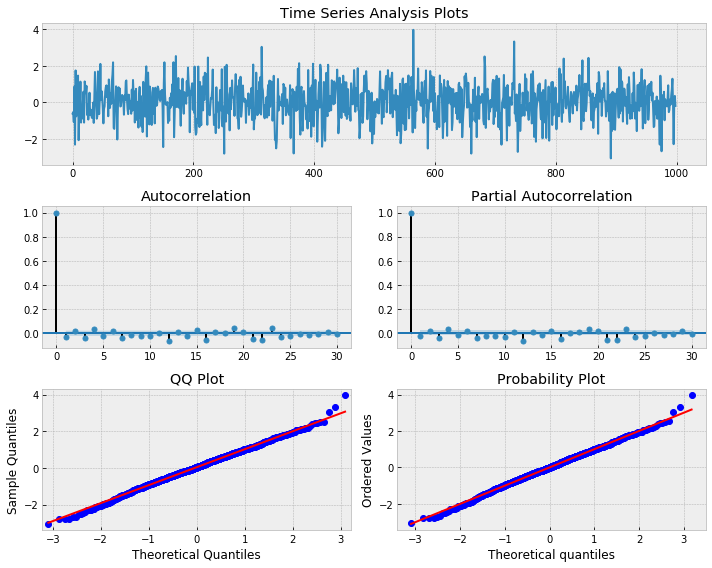

In [12]:
# First difference of simulated Random Walk series

_ = tsplot(np.diff(x), lags = 30)

# First difference of the Ham Index

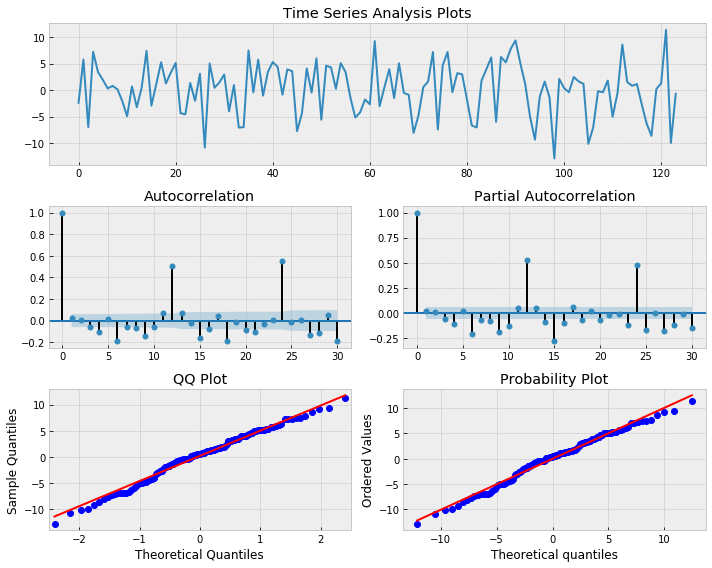

In [39]:
# First difference of Ham_Index 
_ = tsplot(np.diff(data_Ham.Ham_Index), lags =30)

# Looks promising. Let's wait to see how the more complicated models fare. Some concern about the ACF and PACF interpretation.

# Linear Model

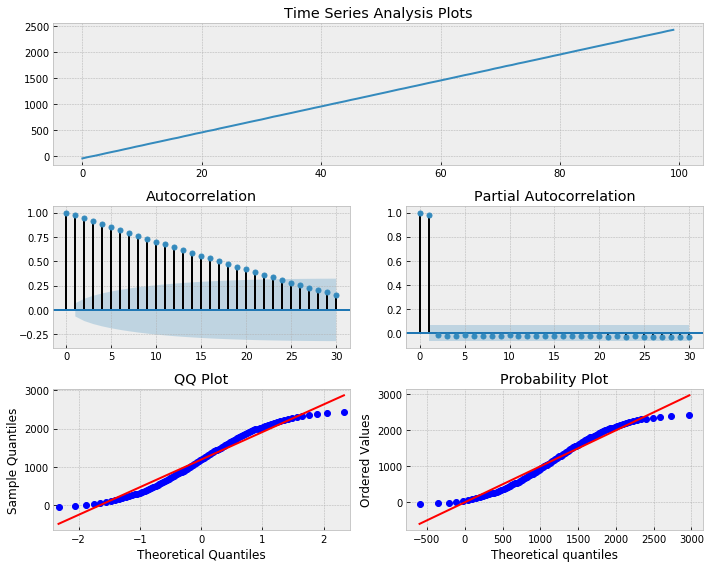

In [15]:
# simulate linear trend
# example Firm ABC sales are -$50 by default and +$25 at every time step

w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50
b1 = 25
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]
    
_ = tsplot(y, lags=30)

# Log Linear Models

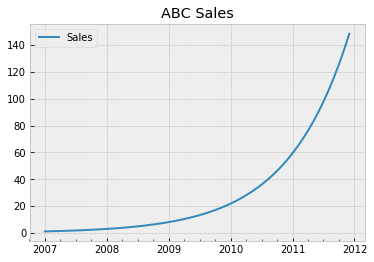

In [18]:
# Simulate ABC exponential growth

#fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

#fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]

#creating dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('ABC Sales')

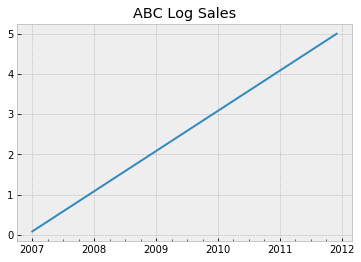

In [19]:
# ABC log sales

with plt.style.context('bmh'):
    pd.Series(np.log(sales), index=idx).plot()
    plt.title('ABC Log Sales')

# Autoregressive Models

# AR(1) 

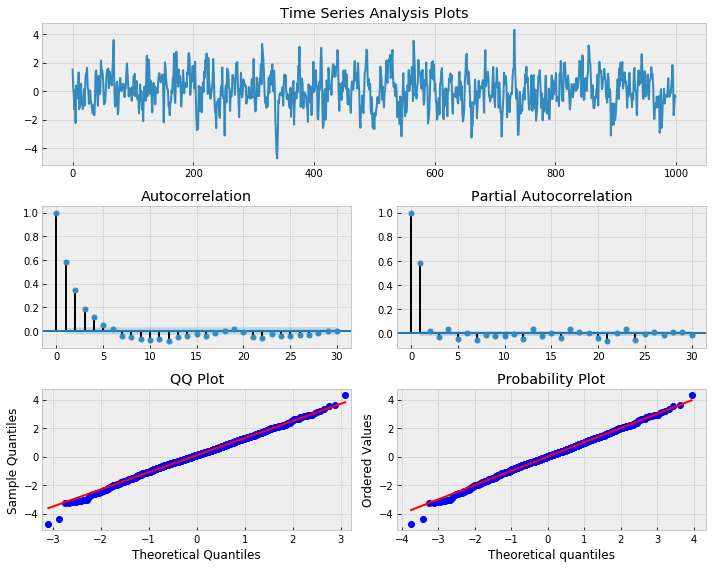

In [21]:
# Simulate an AR(1) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags = 30)

In [23]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag = 30, ic = 'aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag = 30, ic='aic', trend = 'nc')

true_order = 1
p('\nalpha estimate: {:3.5f} | best lag roder = {}'
  .format(mdl.params[0], est_order))
p('\ntrue alpha = {} | true order = {}'
  .format(a, true_order))

Wall time: 10.9 s

alpha estimate: 0.58227 | best lag roder = 1

true alpha = 0.6 | true order = 1


In [77]:
data.axes

[DatetimeIndex(['2007-01-01', '2007-02-01', '2007-03-01', '2007-04-01',
                '2007-05-01', '2007-06-01', '2007-07-01', '2007-08-01',
                '2007-09-01', '2007-10-01',
                ...
                '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
                '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
                '2017-04-01', '2017-05-01'],
               dtype='datetime64[ns]', name='Date', length=125, freq=None),
 Index(['Beef_CS_LiveWgt_PerHd', 'Beef_CS_Slaughter_Cnt', 'Beef_ME_Exp_cwt',
        'Beef_ME_Imp_cwt', 'OP_Electricity_Index', 'OP_Fuel_Oil_Index',
        'OP_Utility_Gas_Index', 'OP_Gasoline_Index', 'OP_Soyabean_Index',
        'OP_Hay_Alfalfa_Index', 'OP_Hay_Others_Prc', 'OP_Corn_Index',
        'Pork_CS_LiveWgt_PerHd', 'Pork_CS_Slaughter_Cnt', 'Pork_ME_Exp_cwt',
        'Pork_ME_Imp_cwt', 'ME_AvgHrInc_Trk_Driver', 'ME_Unemp_rate',
        'Beef_CS_Prod_Qty', 'Pork_CS_Prod_Qty', 'Beef_CS_ColdStrg_Stock_pwt',
        '

In [81]:
data.astype(np.float)
print(type(data))
data2= data.Ham_Index
data2

<class 'pandas.core.frame.DataFrame'>


Date
2007-01-01    172.747
2007-02-01    170.358
2007-03-01    176.106
2007-04-01    169.135
2007-05-01    176.349
2007-06-01    179.754
2007-07-01    181.689
2007-08-01    181.990
2007-09-01    182.777
2007-10-01    182.936
2007-11-01    180.889
2007-12-01    175.954
2008-01-01    176.625
2008-02-01    173.400
2008-03-01    173.875
2008-04-01    181.260
2008-05-01    178.318
2008-06-01    179.421
2008-07-01    184.665
2008-08-01    185.925
2008-09-01    189.218
2008-10-01    194.328
2008-11-01    189.969
2008-12-01    185.401
2009-01-01    186.741
2009-02-01    184.727
2009-03-01    187.811
2009-04-01    176.971
2009-05-01    181.982
2009-06-01    182.422
               ...   
2014-12-01    225.163
2015-01-01    223.955
2015-02-01    225.557
2015-03-01    224.192
2015-04-01    211.320
2015-05-01    213.419
2015-06-01    213.794
2015-07-01    213.388
2015-08-01    215.852
2015-09-01    217.486
2015-10-01    218.647
2015-11-01    208.510
2015-12-01    201.479
2016-01-01    201.281
2016-

In [83]:
# Fitting AR(1) to the Ham Index data

x = data2

mdl = smt.AR(x).fit(maxlag = 30, ic = 'aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag = 30, ic='aic', trend = 'nc')

p('\nalpha estimate: {:3.5f} | best lag roder = {}'
  .format(mdl.params[0], est_order))

C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\linalg\linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  `rcond` * largest_singular_value (again, in modulus)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value en

Wall time: 12.4 s

alpha estimate: 0.93715 | best lag roder = 1


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


# Need to interpret this result.

# AR(2)

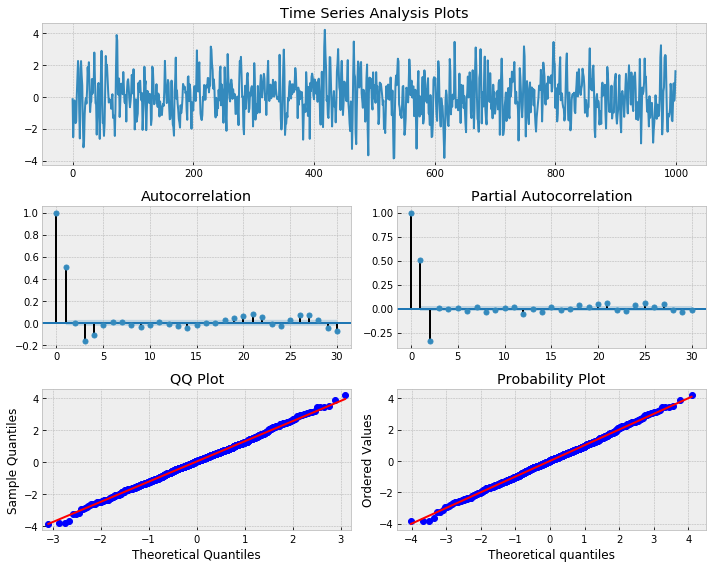

In [26]:
# Simulate AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ar2, lags = 30)

In [28]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag = max_lag, ic = 'aic', trend = 'nc')
est_order = smt.AR(ar2).select_order( maxlag = max_lag, ic = 'aic', trend = 'nc')

true_order = 2
p('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'
  .format(mdl.params[0],mdl.params[1], est_order))
p('\ntrue coefs = {} | true order = {}'
  .format([.666,-.333], true_order))


coef estimate: 0.6760 -0.3393 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


#  Interpret the AR(2) result given below

In [84]:
# Trying again on our series
# Select best lag order for Ham_Index

max_lag = 30
mdl = smt.AR(data2).fit(maxlag = max_lag, ic = 'aic', trend = 'nc')
est_order = smt.AR(data2).select_order( maxlag = max_lag, ic = 'aic', trend = 'nc')

p('best estimated lag order = {}'.format(est_order))

C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\linalg\linalg.py:1817: RuntimeWarning: invalid value encountered in slogdet
  `rcond` * largest_singular_value (again, in modulus)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value en

best estimated lag order = 1


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


# Moving Average

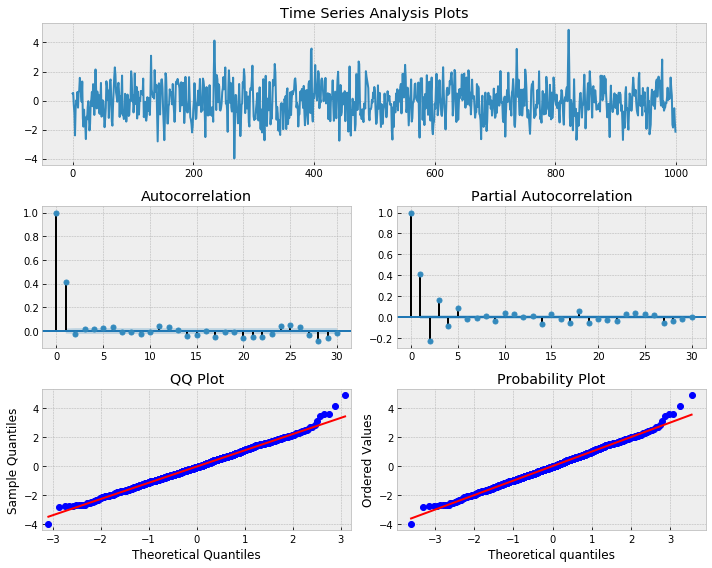

In [85]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alpha equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample = n)
_ = tsplot(ma1, lags =30)

In [89]:
max_lag = 30
mdl = smt.ARMA(ma1, order=(0,1)).fit(maxlag = max_lag, method = 'mle', trend = 'nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1390.513
Method:                           mle   S.D. of innovations              0.972
Date:                Wed, 05 Sep 2018   AIC                           2785.025
Time:                        18:53:15   BIC                           2794.841
Sample:                             0   HQIC                          2788.756
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5874      0.026     22.762      0.000       0.537       0.638
                                    Roots                                    
                  Real          Imaginary           M

# aplying MA1 to our model

In [90]:
max_lag = 30
mdl = smt.ARMA(data2, order=(0,1)).fit(maxlag = max_lag, method = 'mle', trend = 'nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:              Ham_Index   No. Observations:                  125
Model:                     ARMA(0, 1)   Log Likelihood                -756.347
Method:                           mle   S.D. of innovations            101.402
Date:                Wed, 05 Sep 2018   AIC                           1516.695
Time:                        18:57:21   BIC                           1522.351
Sample:                    01-01-2007   HQIC                          1518.993
                         - 05-01-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ma.L1.Ham_Index     0.9792      0.021     45.992      0.000       0.937       1.021
                                    Roots                                    
                  Real          Imagin

C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


# Im not sure, how to interpret this result, MA(1)

# Simulating MA(3) process with betas 0.6, 0.4, 0.2

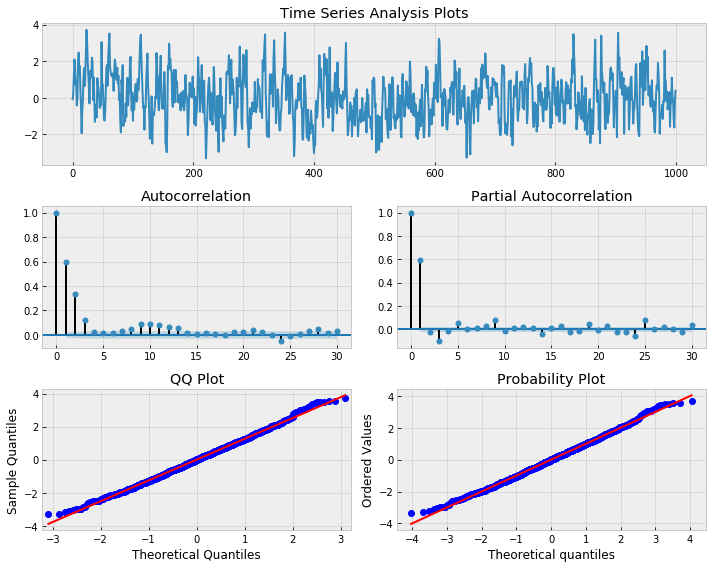

In [91]:
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=30)

In [92]:
# Fit MA(3) model to simulated tiem series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0,3)).fit(maxlag = max_lag, method = 'mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1427.038
Method:                           mle   S.D. of innovations              1.008
Date:                Wed, 05 Sep 2018   AIC                           2862.075
Time:                        19:04:47   BIC                           2881.706
Sample:                             0   HQIC                          2869.536
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6025      0.031     19.322      0.000       0.541       0.664
ma.L2.y        0.4060      0.034     11.806      0.000       0.339       0.473
ma.L3.y        0.1683      0.031      5.420      0.0

In [95]:
max_lag = 30
mdl = smt.ARMA(data2, order=(0,3)).fit(maxlag = max_lag, method = 'mle', trend = 'nc')
p(mdl.summary())
_ = tsplot(mdl.resid, lags = max_lag)

C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

# Model MA(3) does not seem to work, need to fix it

# ARMA(p,q)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7076.176
Method:                           mle   S.D. of innovations              0.996
Date:                Wed, 05 Sep 2018   AIC                          14162.352
Time:                        20:05:35   BIC                          14194.938
Sample:                             0   HQIC                         14173.773
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4730      0.051      9.338      0.000       0.374       0.572
ar.L2.y       -0.2645      0.015    -17.489      0.000      -0.294      -0.235
ma.L1.y        0.5224      0.052     10.089      0.0

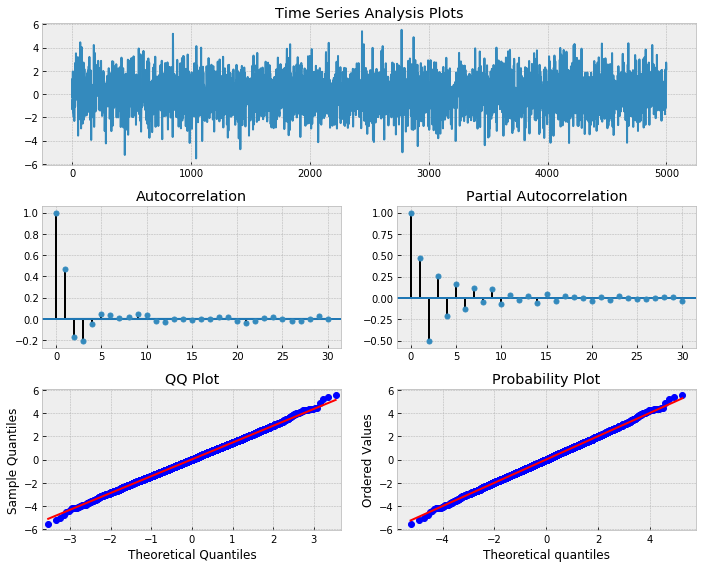

In [96]:
# Simulate an ARMA(2,2) model with alphas=[0.5, -0.25] and beta = [0.5, -0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags = max_lag)

mdl = smt.ARMA(arma22, order=(2,2)).fit(maxlag = max_lag, method = 'mle', trend = 'nc', burnin = burn)
p(mdl.summary())

In [97]:
# Fitting ARMA(2,2) to our data
max_lag = 30

mdl = smt.ARMA(data2, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
p(mdl.summary())

C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

# Model ARMA(2.2) does not seem to work, need to fix it

i is: 0
j is: 0
in loop
in except block
j is: 1
in loop
in except block
j is: 2
in loop
in except block
j is: 3
in loop
in except block
j is: 4
in loop
in except block
i is: 1
j is: 0
in loop
in except block
j is: 1
in loop
in except block
j is: 2
in loop
in except block
j is: 3
in loop
in except block
j is: 4
in loop
in except block
i is: 2
j is: 0
in loop
in except block
j is: 1
in loop
in except block
j is: 2
in loop
in except block
j is: 3
in loop
in except block
j is: 4
in loop
in except block
i is: 3
j is: 0
in loop
in except block
j is: 1
in loop
in except block
j is: 2
in loop
in except block
j is: 3
in loop
in except block
j is: 4
in loop
in except block
i is: 4
j is: 0
in loop
in except block
j is: 1
in loop
in except block
j is: 2
in loop
in except block
j is: 3
in loop
in except block
j is: 4
in loop
in except block
aic:    inf | order: None


AttributeError: 'NoneType' object has no attribute 'summary'

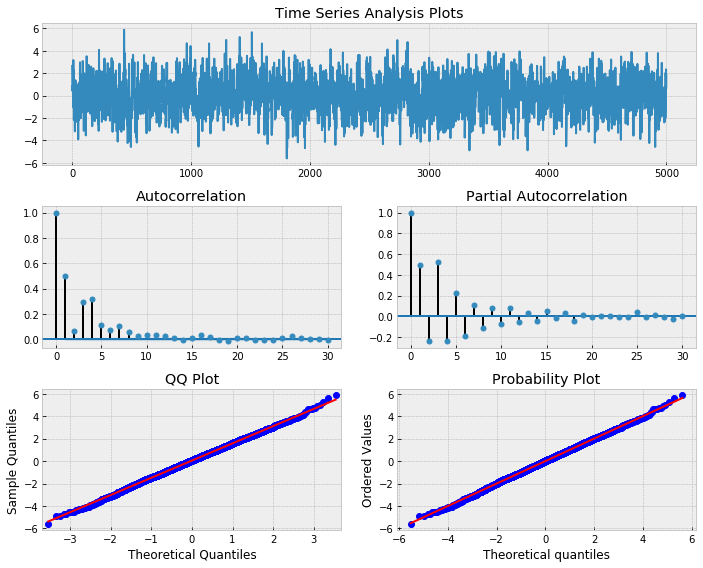

In [110]:
# Simulate an ARMA(3,2) mdel with alphas=[0.5, -0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.25,0.4])
betas = np.array([0.5,-0.3])

ar = np.r_[1,-alphas]
ma = np.r_[1,betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma32, lags=max_lag)

# pick best order by aic
# smallest aic value wins
best_aic = np.inf
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    p("i is: {}".format(i))
    for j in rng:
        p("j is: {}".format(j))
        try:
            p("in loop")
            tmp_mdl = smt.ARMA(arma32, order(i,j)).fit(method = 'mle', trend = 'nc')
            tmp_aic = tmp_mdl.aic
            p(tmp_mdl.summary())
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i,j)
                best_mdl = tmp_mdl
        except: 
            p("in except block")
            continue

p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
p(best_mdl.summary())

# mdl = smt.ARMA(arma32, order=(3, 2)).fit(
#     maxlag=max_lag, method='mle', trend='nc', burnin=burn)
# p(mdl.summary())

# Stationarity problem using the above on our data

# ARIMA might solve the statinarity problem, so here come ARIMA:

i is 0
d is 0
j is 0
entered except block
j is 1
j is 2
entered except block
j is 3
entered except block
j is 4
entered except block
d is 1
j is 0
entered except block
j is 1
j is 2
j is 3
j is 4


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base

i is 1
d is 0
j is 0
j is 1
entered except block
j is 2
entered except block
j is 3
entered except block
j is 4
entered except block
d is 1
j is 0
j is 1


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base

j is 2
j is 3


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


j is 4


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


i is 2
d is 0
j is 0
j is 1
entered except block
j is 2
entered except block
j is 3
entered except block
j is 4


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base

entered except block
d is 1
j is 0
j is 1


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


j is 2


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


j is 3


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params)

entered except block
j is 4
i is 3
d is 0
j is 0
j is 1
entered except block
j is 2
entered except block
j is 3


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


entered except block
j is 4
entered except block
d is 1
j is 0
j is 1


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base

j is 2


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\t

j is 3


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


j is 4
i is 4
d is 0
j is 0
j is 1


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


entered except block
j is 2
entered except block
j is 3
entered except block
j is 4
entered except block
d is 1
j is 0


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base

j is 1


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


j is 2


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


j is 3


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


j is 4


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: 736.96386 | order: (2, 1, 2)


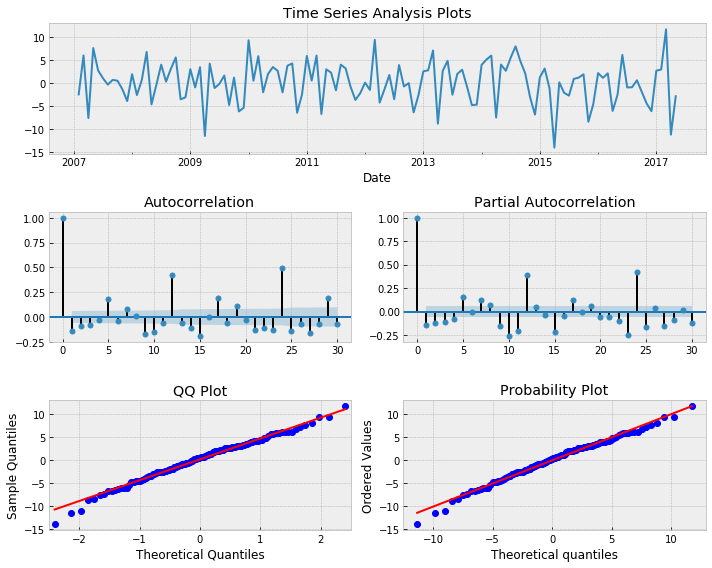

In [113]:
# Fit ARIMA(p,d,q) model to Ham INdex
# pick best order and final model based on aic

best_aic = np.inf
best_order = None
best_mdl = None

pq_rng = range(5)
d_rng = range(2)
for i in pq_rng:
    p("i is {}".format(i))
    for d in d_rng:
        p("d is {}".format(d))
        for j in pq_rng:
            p("j is {}".format(j))
            try:
                tmp_mdl = smt.ARIMA(data2, order=(i,d,j)).fit(method = 'mle', trend = 'nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i,d,j)
                    best_mdl = tmp_mdl
            except: 
                p("entered except block")
                continue

p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


#ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags = 30)

In [114]:
# Creating a forecast

n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps = n_steps)
_, err99, ci99 = best_mdl.forecast(steps = n_steps, alpha = 0.01)

idx = pd.date_range(data.index[-1], periods = n_steps, freq = 'D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]),
                     index = idx, columns = ['forecast', 'lower_ci_95', 'uper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]),
                    index = idx, columns = ['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,uper_ci_95,upper_ci_99
2017-05-01,196.070675,187.351969,184.612353,204.789381,207.528997
2017-05-02,198.176989,185.812286,181.927015,210.541691,214.426962
2017-05-03,199.399248,184.193060,179.414929,214.605437,219.383567
2017-05-04,199.410008,181.766979,176.223137,217.053038,222.596880
2017-05-05,198.206793,178.387438,172.159746,218.026148,224.253841


KeyError: Timestamp('2007-01-01 00:00:00')

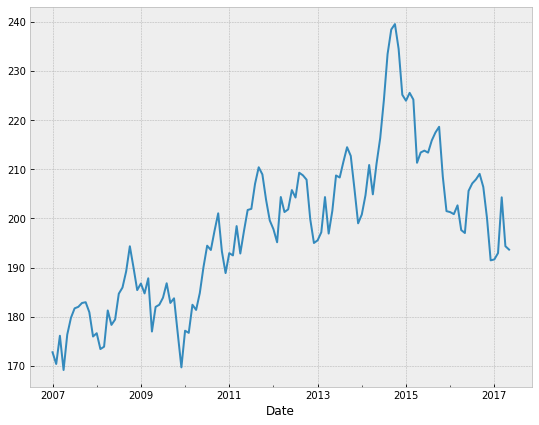

In [122]:
# Plot 21 day forecast for the Ham Index

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = data2.iloc[-500:].copy()
ts.plot(ax=ax, label = 'FOrecast')

pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style= 'r-', label = 'In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha = 0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Month/Day Forecast \nARIMA{}'.format(n_teps, best_order))
plt.legend(loc='best', fontize=10)

In [121]:
 data2.iloc[-500:]

Date
2007-01-01    172.747
2007-02-01    170.358
2007-03-01    176.106
2007-04-01    169.135
2007-05-01    176.349
2007-06-01    179.754
2007-07-01    181.689
2007-08-01    181.990
2007-09-01    182.777
2007-10-01    182.936
2007-11-01    180.889
2007-12-01    175.954
2008-01-01    176.625
2008-02-01    173.400
2008-03-01    173.875
2008-04-01    181.260
2008-05-01    178.318
2008-06-01    179.421
2008-07-01    184.665
2008-08-01    185.925
2008-09-01    189.218
2008-10-01    194.328
2008-11-01    189.969
2008-12-01    185.401
2009-01-01    186.741
2009-02-01    184.727
2009-03-01    187.811
2009-04-01    176.971
2009-05-01    181.982
2009-06-01    182.422
               ...   
2014-12-01    225.163
2015-01-01    223.955
2015-02-01    225.557
2015-03-01    224.192
2015-04-01    211.320
2015-05-01    213.419
2015-06-01    213.794
2015-07-01    213.388
2015-08-01    215.852
2015-09-01    217.486
2015-10-01    218.647
2015-11-01    208.510
2015-12-01    201.479
2016-01-01    201.281
2016-

# ARCH

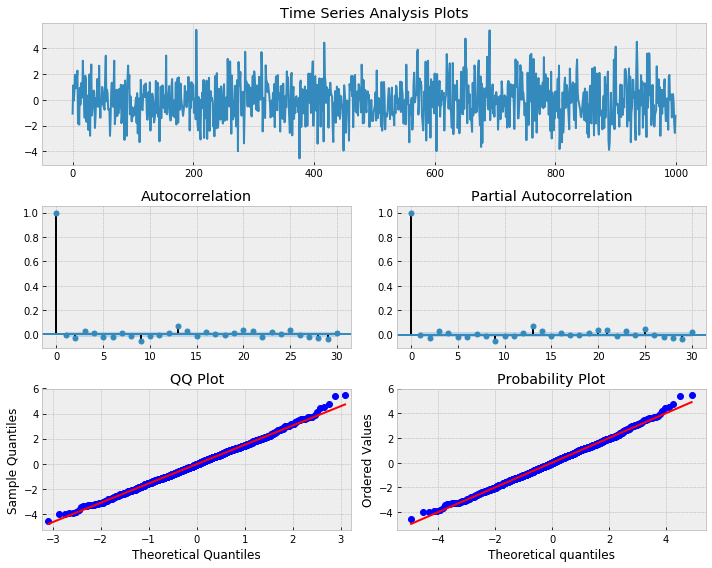

In [123]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 i between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))
    
#Simulated ARCH(1) series, looks like white noise
tsplot(Y, lags = 30)

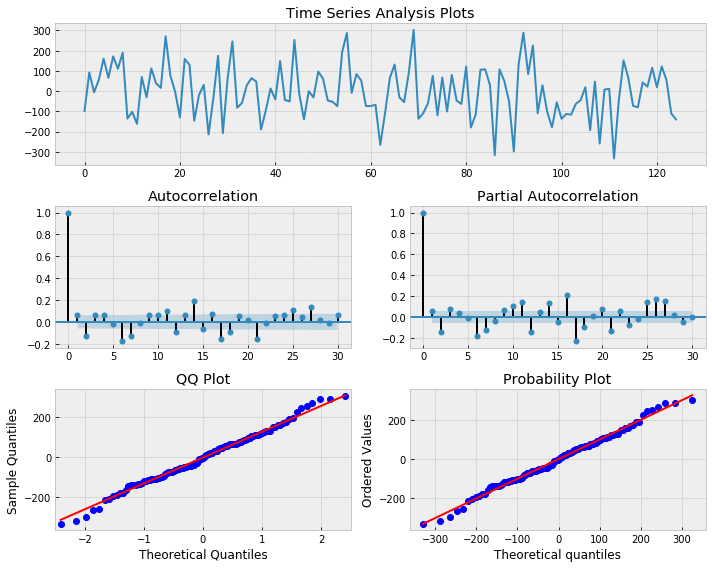

In [124]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 i between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = data2
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))
    
#Simulated ARCH(1) series, looks like white noise
tsplot(Y, lags = 30)

# Well the above looks promising

# GARCH

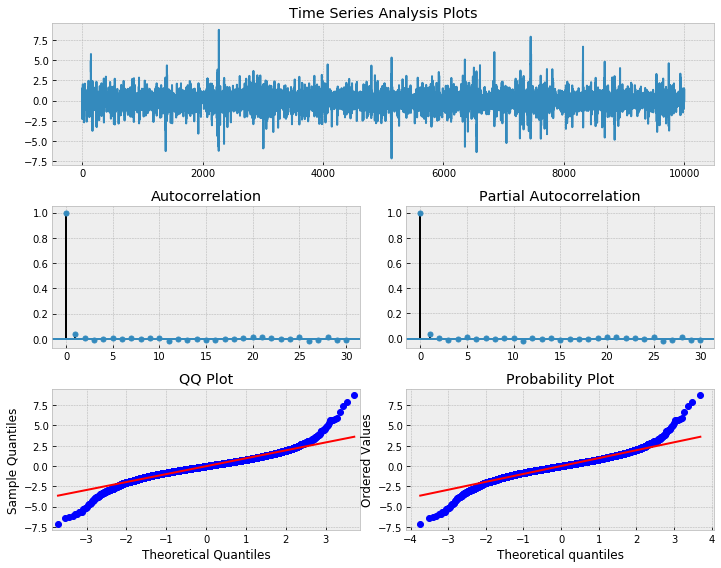

In [128]:
# Simulating a GARCH(1,1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1,n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])
    
_ = tsplot(eps, lags = 30)

In [129]:
# Fit a GARCH(1,1) model to our simulated data2 series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
p(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592659128462
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.303267318555
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Thu, Sep 06 2018   Df Residuals:                     9996
Time:      

C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:354: RuntimeWarning: invalid value encountered in subtract
  xo = x - x.mean()
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1263: RuntimeWarning: invalid value encountered in subtract
  X -= X.mean()                  # automatically demean's X
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:192: RuntimeWarning: invalid value encountered in subtract
  scale = np.sqrt(((data - loc)**2).mean())
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  arrmean = arrmean.dtype.type(a

Iteration:      5,   Func. Count:     70,   Neg. LLF: nan
Iteration:     10,   Func. Count:    150,   Neg. LLF: nan
Iteration:     15,   Func. Count:    230,   Neg. LLF: nan
Iteration:     20,   Func. Count:    310,   Neg. LLF: nan
Iteration:     25,   Func. Count:    390,   Neg. LLF: nan
Iteration:     30,   Func. Count:    470,   Neg. LLF: nan
Iteration:     35,   Func. Count:    550,   Neg. LLF: nan
Iteration:     40,   Func. Count:    630,   Neg. LLF: nan
Iteration:     45,   Func. Count:    710,   Neg. LLF: nan
Iteration:     50,   Func. Count:    790,   Neg. LLF: nan
Iteration:     55,   Func. Count:    870,   Neg. LLF: nan
Iteration:     60,   Func. Count:    950,   Neg. LLF: nan
Iteration:     65,   Func. Count: 1.03e+03,   Neg. LLF: nan
Iteration:     70,   Func. Count: 1.11e+03,   Neg. LLF: nan
Iteration:     75,   Func. Count: 1.19e+03,   Neg. LLF: nan
Iteration:     80,   Func. Count: 1.27e+03,   Neg. LLF: nan
Iteration:     85,   Func. Count: 1.35e+03,   Neg. LLF: nan
Iter

C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\volatility.py:804: RuntimeWarning: invalid value encountered in sign
  sresids = sign(resids)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\mean.py:508: RuntimeWarning: invalid value encountered in subtract
  y = y - np.mean(y)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\mean.py:587: RuntimeWarning: invalid value encountered in subtract
  e = y - x.dot(regression_params)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\mean.py:815: RuntimeWarning: invalid value encountered in subtract
  return y - params
C:\Users\kmo

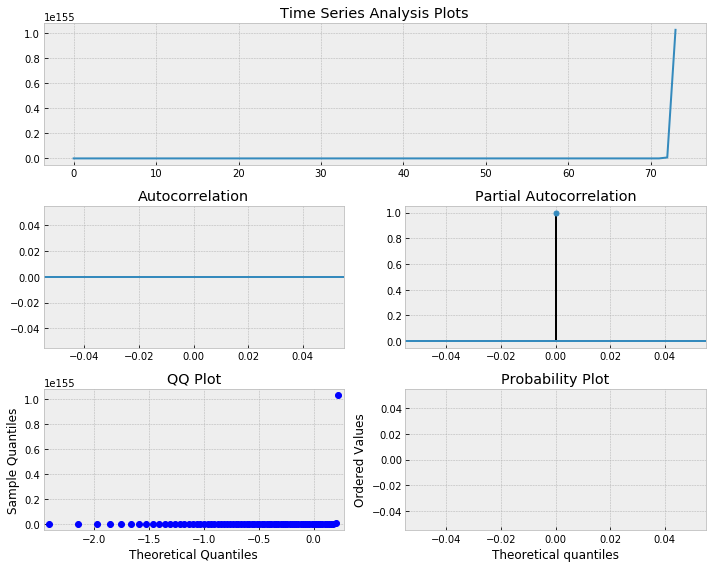

In [131]:
# Simulating a GARCH(1,1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = len(data2)
w = data2
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1,n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])
    
_ = tsplot(eps, lags = 30)

# Fit a GARCH(1,1) model to our simulated data2 series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
p(res.summary())

In [137]:
eps

array([0.00000000e+000, 7.61864137e+001, 9.48759502e+003, 1.13469419e+006,
       1.41495096e+008, 1.79849462e+010, 2.31061087e+012, 2.97346812e+014,
       3.84302993e+016, 4.97120700e+018, 6.35862043e+020, 7.91135785e+022,
       9.88080695e+024, 1.21152027e+027, 1.48955713e+029, 1.90918693e+031,
       2.40731324e+033, 3.05418244e+035, 3.98812366e+037, 5.24318557e+039,
       7.01530323e+041, 9.63985430e+043, 1.29491618e+046, 1.69762727e+048,
       2.24166554e+050, 2.92812715e+052, 3.88865825e+054, 4.86620699e+056,
       6.26192950e+058, 8.07745083e+060, 1.05010799e+063, 1.38702221e+065,
       1.79271118e+067, 2.32907800e+069, 2.90948443e+071, 3.49074362e+073,
       4.37226985e+075, 5.46295655e+077, 7.04675826e+079, 9.03715582e+081,
       1.18091965e+084, 1.58727598e+086, 2.18240627e+088, 2.98712312e+090,
       4.17091878e+092, 5.92922910e+094, 8.10376532e+096, 1.08224809e+099,
       1.47639985e+101, 2.00929757e+103, 2.81932075e+105, 3.84451166e+107,
       5.36779132e+109, 7

# the eps and sigsq have inf in them, ridiculous.

# Trial for the best results:

C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base

entered except block
entered except block
entered except block
entered except block
entered except block


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


entered except block
entered except block
entered except block
entered except block


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base

entered except block
entered except block
entered except block
entered except block


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base

entered except block


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base

entered except block
entered except block
entered except block
entered except block


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\mod

entered except block
entered except block
entered except block
entered except block


C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\kmoudgalya\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base

aic: 736.96386 | order: (2, 1, 2)


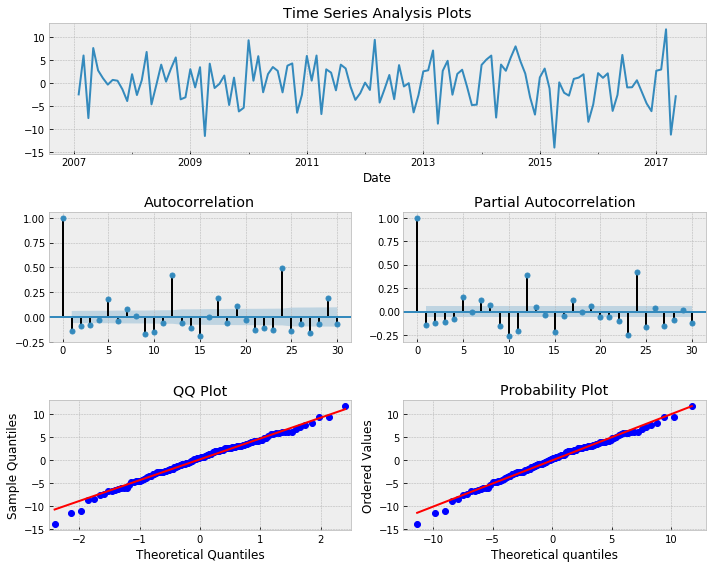

In [142]:
def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None
    
    pq_rng = range(5)
    d_rng = range(2)
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                    method = 'mle', trend = 'nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i,d,j)
                        best_mdl = tmp_mdl
                except:
                    p("entered except block")
                    continue
    
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

res_tup = _get_best_model(data2)
_ = tsplot(best_mdl.resid, lags = 30 )

# the ACF and PACF still have some issues.

In [145]:
# We can fit the arch model using the best fit arima model parameters

p_ = order[2]
o_ = order[1]
q_ = order[2]

#Using student T distribution usually provides better fit
am = arch_model(data2, p=_, o=o_, q=q_, dist="StudentsT")
res = am.fit(update_freq = 5, disp = 'off')
p(res.summary())

NameError: name 'order' is not defined

# order not defined problem

In [6]:
import pyramid

In [9]:
data_Ham

,Beef_CS_LiveWgt_PerHd,Beef_CS_Slaughter_Cnt,Beef_ME_Exp_cwt,Beef_ME_Imp_cwt,OP_Electricity_Index,OP_Fuel_Oil_Index,OP_Utility_Gas_Index,OP_Gasoline_Index,OP_Soyabean_Index,OP_Hay_Alfalfa_Index,...,ME_CPI,WR_AvG_Temp,WR_Avg_Rainfall,Extreme_Draught_Value,Dollar_Index,Egg_Index,Ground_Beef_Index,Round_Index,Beef_Steak_Index,Ham_Index
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,1290,2800.3,88015.60,270127.44,168.903,232.476,217.428,73.0,109.0,212.1,...,202.42,-5.46,46.39,80.1480,94.812,176.588,177.805,146.626,146.440,172.747
2007-02-01,1274,2561.2,88273.90,223064.59,168.870,238.651,218.173,60.1,105.6,215.8,...,203.50,-4.56,33.98,81.4600,94.643,190.534,180.997,151.905,146.366,170.358
2007-03-01,1260,2793.0,92747.49,276724.42,169.346,245.141,222.221,66.1,108.3,221.4,...,205.35,1.14,46.06,86.0475,94.397,184.878,181.778,152.622,150.995,176.106
2007-04-01,1235,2701.4,105205.87,301300.99,169.385,249.477,220.779,71.1,113.1,236.1,...,206.69,6.76,48.40,86.4200,93.274,178.626,182.456,158.206,155.146,169.135
2007-05-01,1232,3051.4,126889.87,302812.03,172.342,250.627,221.801,86.1,118.4,265.6,...,207.95,13.34,56.15,93.0160,92.615,183.757,184.626,155.751,154.565,176.349
2007-06-01,1250,3076.5,132357.45,280394.06,184.194,251.241,223.313,86.5,122.8,252.7,...,208.35,18.14,62.40,99.7425,92.351,176.265,185.566,156.625,153.310,179.754
2007-07-01,1269,2903.1,165174.68,308686.52,184.408,257.111,219.865,81.6,128.1,252.7,...,208.30,20.98,66.75,113.9360,90.982,188.075,184.878,154.001,151.872,181.689
2007-08-01,1279,3132.1,132838.23,253077.10,184.081,257.371,211.181,71.3,125.7,252.7,...,207.92,20.59,59.58,136.5100,91.185,196.412,185.111,154.855,151.828,181.990
2007-09-01,1290,2664.6,126755.30,212153.40,184.365,265.137,208.211,73.7,134.2,249.0,...,208.49,15.89,57.15,129.3500,90.101,211.646,186.444,157.229,153.683,182.777


In [11]:
from pyramid.arima import ARIMA

fit = ARIMA(order=(1,1,1), seasonal_order=(0, 1, 1, 12)).fit(y=Ham_Index)

AttributeError: module 'pyramid' has no attribute 'arima'